# Segmentation Learning

In this notebook we'll use the centre of gravity metric and attempt to learn from the vocal/whispered database from DyNaVoiCeR

In [62]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
from scipy.signal import lfilter, spectrogram
from scipy.io import loadmat, wavfile
from IPython.display import Audio
from voicerUtils import *

FS = 22050
N = 1024; N2 = N//2

Let's first load the voice data and the...

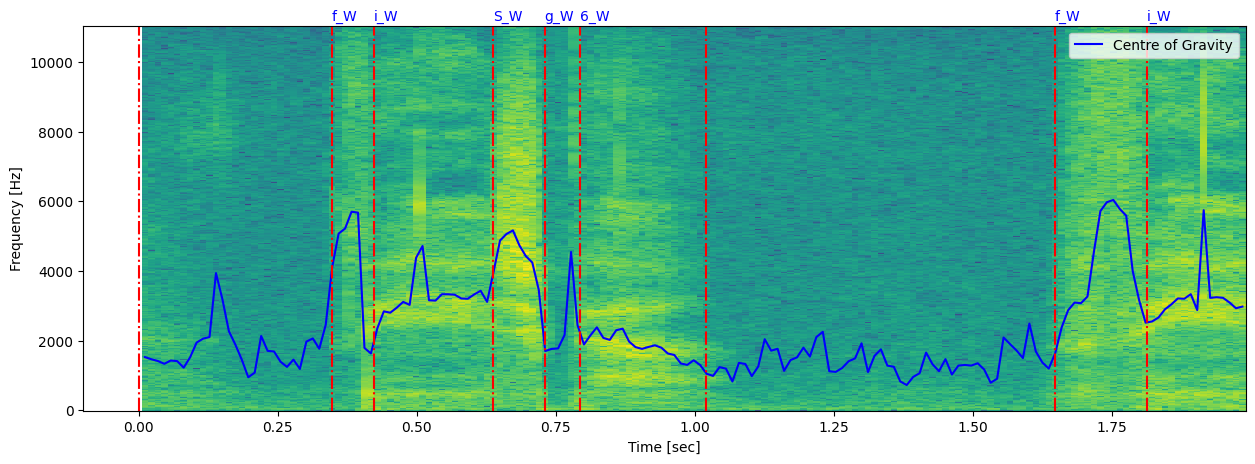

In [72]:
import textgrids
import os

DATA_PATH = '/home/jorgep/Documents/bd_20_oradores_22050/'

IN_AUDIO    = DATA_PATH + 'SPF01/SPF01_33_02.wav'
IN_TEXTGRID = DATA_PATH + 'SPF01/SPF01_33_02.TextGrid' 

try:
    grid = textgrids.TextGrid(IN_TEXTGRID)
except:
    print('Error reading TextGrid')
    exit()

# Load audio
fs, audio = wavfile.read(IN_AUDIO)
audio = audio.astype(np.float32)
audio = audio[:2*FS]

# Get phone time and label
phones = grid['phones']
phonemes = []
for phone in phones:
    phonemes.append((phone.xmin, phone.text))

# Get spectrogram
f, t, Sxx = spectrogram(audio, fs, nperseg=N2, noverlap=N2//2, nfft=N)

# compute centre of gravity and energy
f_cog = np.sum(f[:, None] * Sxx, axis=0) / np.sum(Sxx, axis=0)
energy = np.sum(Sxx, axis=0)

# Plot spectrogram
plt.figure(figsize=(15, 5))
plt.pcolormesh(t, f, 10*np.log10(Sxx))
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.plot(t, f_cog, 'b', label='Centre of Gravity')
plt.legend()

# Plot phones and label them
for pho in phonemes:
    if pho[0] > t[-1]:
        break
    plt.axvline(x=pho[0], color='r', linestyle='-.')
    plt.text(pho[0], FS/2+160, pho[1], color='b')

""" plt.twinx()
plt.plot(t, energy/max(energy), 'r')
plt.ylabel('Relative Energy') """

Audio(data=audio, rate=fs)



Have to still figure out a way to determine all phonemes in the database. And which of the whispered phonemes are supposed to vocalized. I'll refer to these as vocalic whispered phonemes.

In [35]:
def get_textgrid_files(data_path):
    """Function to retrieve all TextGrid files ending with '_02.TextGrid' in the given path."""
    textgrid_files = []
    for root, dirs, files in os.walk(data_path):
        for file in files:
            if file.endswith('_02.TextGrid'):
                textgrid_files.append(os.path.join(root, file))
    return textgrid_files

def process_textgrid_file(textgrid_file):
    """Function to process a TextGrid file and extract phonemes."""
    try:
        grid = textgrids.TextGrid(textgrid_file)
        phones = grid['phones']
        phonemes = {phone.text for phone in phones if phone.text.strip()}
        return phonemes
    except Exception as e:
        print(f"Error reading TextGrid {textgrid_file}: {e}")
        return set()

textgrid_files = get_textgrid_files(DATA_PATH)
unique_phonemes = set()

for textgrid_file in textgrid_files:
    phonemes = process_textgrid_file(textgrid_file)
    unique_phonemes.update(phonemes)

print("Unique phonemes found:")
for phoneme in sorted(unique_phonemes):
    print(phoneme)

Unique phonemes found:
1_W
1_W_0
4-W
4_W
4_W_o
4_o_W
4_w
6
6_0
6_W
6_W ou 1_W?
6_W_0
6_W_v
6_w
6j_W
6~
6~_W
6~j~
6~j~_W
6~w~
6~w~_W
A_w
E
E_W
E_W_^
E_w
L_W
L_W_0
N _W
N_W
O
O_
O_W
R_W
R_w
S
S_W
S_W?^
S_W\
S_W_^
S_w
Z_0
Z_W
Z_W_^
\
a_0
a_W
a_W_0
a_W_v
a_w
aj_W
b_W
b_W?
b_o_W
d_W
e_W
e_W_0
ew_W
e~_W
f_W
g-W
g_W
g_W_0
i
i1_W
i_0_W
i_W
i_W_0
i_w
iw_W
j6_W
k_W
l
l_W
l_W_0
l_Ww
l_w
m_W
m_W_0
n_W
n_W_0
o_W
o_W_v
p_W
s
s_W
t_W
t_w
u
u_0_W
u_W
u_WE
u_W_0
v?
v_W
v_W ou b_W?
v_W?
v_w
w6_W
wa_W
z_W
z_W_^
z_w
103


## TEST SUBJECT FUNDAMENTAL FREQUENCY ANALYSIS

Fundamental frequency average: 127.66 Hz


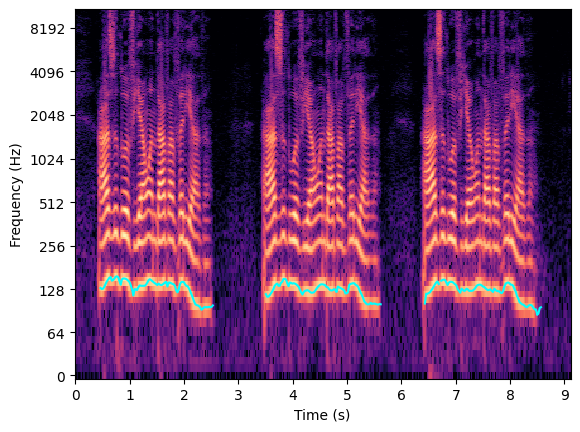

In [6]:
import librosa
import matplotlib.pyplot as plt
import numpy as np

DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'

TEST_SUBJECT = 'SPM18' # 'SPF05' 'SPF12' 'SPM14' 'SPM18'
TEST_PHRASE = 'AviaoVocal' # 'TiagoVocal', 'AviaoVocal'

IN_AUDIO_FILE = DATA_PATH + 'processed/' + TEST_SUBJECT + '_' + TEST_PHRASE + '.wav'
#IN_AUDIO_FILE = DATA_PATH + 'resultsEHLA/segmented/' + 'SPM18_Aviao_3_segmentedF0.wav'

# Read audio 
y, sr = librosa.load(IN_AUDIO_FILE, sr=None)  # Load audio file
f0, voiced_flag, voiced_probs = librosa.pyin(y, sr = sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
times = librosa.times_like(f0, sr=sr)

D = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max)
fig, ax = plt.subplots()
img = librosa.display.specshow(D, x_axis='time', y_axis='log', sr=sr, ax=ax)
ax.plot(times, f0, label='f0', color='cyan')
ax.set_ylabel('Frequency (Hz)')
ax.set_xlabel('Time (s)')

plt.savefig('/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/txt/meec-distrib-v2022/figures/chapter7/f0analysis.pdf', format='pdf', dpi = 300, bbox_inches='tight')

#ax.set_ylim([128, 256])
# compute fundamental frequency average
f0_mean = np.mean(f0[voiced_flag])
print(f'Fundamental frequency average: {f0_mean:.2f} Hz')

In [20]:
import librosa
import numpy as np
import os

DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
TEST_SUBJECTS = ['SPF05', 'SPF12', 'SPM14', 'SPM18']
TEST_PHRASES = ['TiagoVocal', 'AviaoVocal']
RESULTS_FILE = 'pitch_results.md'

# Function to calculate pitch statistics
def calculate_pitch_stats(audio_file):
    y, sr = librosa.load(audio_file, sr=None)  # Load audio file
    f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = np.mean(f0[voiced_flag]) if np.any(voiced_flag) else 0.0  # Calculate mean f0 for voiced frames
    return f0_mean

# Initialize Markdown table header
markdown_table = "| Test Subject | Test Phrase | Avg Fundamental Frequency (Hz) |\n"
markdown_table += "|--------------|-------------|--------------------------------|\n"

# Iterate through all combinations of test subjects and phrases
for subject in TEST_SUBJECTS:
    for phrase in TEST_PHRASES:
        # Construct input audio file path
        in_audio_file = os.path.join(DATA_PATH, 'processed', f'{subject}_{phrase}.wav')

        # Calculate average fundamental frequency
        avg_f0 = calculate_pitch_stats(in_audio_file)

        # Append to Markdown table
        markdown_table += f"| {subject} | {phrase} | {avg_f0:.2f} |\n"

# Print Markdown table
print(markdown_table)

# Write Markdown table to a file
with open(RESULTS_FILE, 'w') as file:
    file.write(markdown_table)

print(f"Results written to {RESULTS_FILE}")


| Test Subject | Test Phrase | Avg Fundamental Frequency (Hz) |
|--------------|-------------|--------------------------------|
| SPF05 | TiagoVocal | 187.78 |
| SPF05 | AviaoVocal | 195.61 |
| SPF12 | TiagoVocal | 174.72 |
| SPF12 | AviaoVocal | 156.44 |
| SPM14 | TiagoVocal | 112.12 |
| SPM14 | AviaoVocal | 110.49 |
| SPM18 | TiagoVocal | 127.54 |
| SPM18 | AviaoVocal | 127.66 |

Results written to pitch_results.md


In [19]:
import librosa
import numpy as np
import os

DATA_PATH = '/home/jorgep/OneDrive_JPais/Faculdade/Mestrado/Tese/data/'
TEST_SUBJECTS = ['SPF05', 'SPF12', 'SPM14', 'SPM18']
TEST_PHRASES = ['TiagoVocal', 'AviaoVocal']
RESULTS_FILE = 'pitch_results.md'

# Function to calculate pitch statistics
def calculate_pitch_stats(audio_file):
    y, sr = librosa.load(audio_file, sr=None)  # Load audio file
    f0, voiced_flag, voiced_probs = librosa.pyin(y, sr=sr, fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
    f0_mean = np.mean(f0[voiced_flag]) if np.any(voiced_flag) else 0.0  # Calculate mean f0 for voiced frames
    return f0_mean

# Initialize Markdown table header
markdown_table = "| Test Subject | Geometric Avg Fundamental Frequency (Hz) |\n"
markdown_table += "|--------------|---------------------------------------|\n"

# Iterate through all test subjects
for subject in TEST_SUBJECTS:
    # Initialize an array to store fundamental frequencies for both phrases
    f0_phrases = []

    # Iterate through all phrases for the current test subject
    for phrase in TEST_PHRASES:
        # Construct input audio file path
        in_audio_file = os.path.join(DATA_PATH, 'processed', f'{subject}_{phrase}.wav')

        # Calculate average fundamental frequency for the current phrase
        avg_f0 = calculate_pitch_stats(in_audio_file)
        
        # Append to the list
        f0_phrases.append(avg_f0)

    # Calculate geometric average of fundamental frequencies for the current test subject
    geometric_avg_f0 = np.sqrt(f0_phrases[0] * f0_phrases[1])  # Geometric mean calculation

    # Append to Markdown table
    markdown_table += f"| {subject} | {geometric_avg_f0:.2f} |\n"

# Print Markdown table
print(markdown_table)

# Write Markdown table to a file
with open(RESULTS_FILE, 'w') as file:
    file.write(markdown_table)

print(f"Results written to {RESULTS_FILE}")


| Test Subject | Geometric Avg Fundamental Frequency (Hz) |
|--------------|---------------------------------------|
| SPF05 | 191.65 |
| SPF12 | 165.33 |
| SPM14 | 111.30 |
| SPM18 | 127.60 |

Results written to pitch_results.md


In [1]:
import numpy as np
from IPython.display import Audio

N = 1024; Fs = 22050

noise = np.random.normal(0, 0.1, N)

# output noise as a C compatible array
print('{', end='')
for i in range(N):
    print(f'{noise[i]:.6f}, ', end='')
print('};')

{0.272315, 0.045077, 0.130229, 0.116203, 0.010254, -0.030482, -0.051210, 0.016789, -0.049025, 0.130256, -0.027231, -0.079430, 0.043013, 0.017471, 0.137698, -0.180322, -0.132249, -0.073982, -0.073859, 0.063953, 0.058174, 0.031769, 0.104333, 0.207267, 0.036968, -0.063785, 0.069933, -0.153263, 0.029176, -0.142531, 0.089934, 0.077568, 0.053402, -0.036212, 0.062751, 0.074426, 0.045147, 0.003818, 0.194189, -0.059507, -0.092830, -0.186645, 0.132866, -0.009183, 0.008263, -0.233295, 0.061763, 0.085726, -0.068145, -0.080727, 0.138120, -0.086172, 0.061734, -0.011756, 0.060390, 0.153721, -0.122240, -0.109923, -0.022641, 0.049923, 0.108675, -0.002336, 0.006612, -0.047333, 0.094963, -0.075041, -0.058586, 0.060000, 0.007000, -0.024865, -0.112674, 0.348913, 0.078905, -0.091921, -0.012808, 0.022528, 0.048195, 0.006306, -0.052841, -0.096290, 0.038625, -0.076127, 0.062350, 0.013558, -0.023687, 0.103788, -0.027927, -0.272991, -0.067432, -0.010782, 0.003847, 0.003138, 0.180022, -0.056631, 0.054415, 0.05644

In [18]:
noise = np.random.normal(0, 0.1, Fs*5)
Audio(noise, rate=Fs)